<a href="https://colab.research.google.com/github/donyeun/AMLSII_19-20_SN18154195/blob/master/AMLS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries and Variables

* Reading `config.yaml` which contains all ML parameters as well as filepaths
* Import all dependencies and libraries







In [0]:
# load configuration file that store all the constant and parameters settings
import yaml
CONFIG_YAML_FILEPATH = '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/config.yaml'
with open(CONFIG_YAML_FILEPATH, 'r') as file:
  cfg = yaml.safe_load(file)

In [3]:
# install additional dependencies
! pip install -r {cfg['paths']['requirements']}

import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv
import numpy as np
import tensorboard as tb
import tensorflow as tf


# load the TensorBoard notebook extension
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
%load_ext tensorboard

# Load Dataset and Data Preprocessing

## Preprocess Additional Dataset
In task A, there are some additional datasets (sms and livejournal datasets) that were given from the competition apart from the standard twitter corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [4]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None, quoting=csv.QUOTE_NONE)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames and Cleaning Dataset



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep="\t", header=None, quoting=csv.QUOTE_NONE)
      print('shape : ', dataset_per_file_dfs[filename].shape, '\tfilename: ', filename)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  # drop unnecessary column
  df = df.drop(columns=drop_column_list)
  
  # rename column
  df.columns = new_column_name_list

  # remove row in dataframe if the 'text' or 'sentiment' column value is missing
  df = df.dropna(subset=['sentiment', 'text'], how='any').reset_index(drop=True)
  
  # remove row if the sentiment is not 'positive', 'negative' or 'neutral'
  # this happens in the dataset, for example, there are some rows
  # where its sentiments are 'off topic'
  valid_sentiments = ['positive', 'negative', 'neutral']
  df = df[df['sentiment'].isin(valid_sentiments)].reset_index(drop=True)
  return df

In [7]:
# read dataset files and append it as one pandas dataframe
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])

task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])

shape :  (2000, 3) 	filename:  twitter-2016devtest-A.txt
shape :  (1999, 3) 	filename:  twitter-2016dev-A.txt
shape :  (6000, 3) 	filename:  twitter-2016train-A.txt
shape :  (1654, 3) 	filename:  twitter-2013dev-A.txt
shape :  (3547, 3) 	filename:  twitter-2013test-A.txt
shape :  (9684, 3) 	filename:  twitter-2013train-A.txt
shape :  (1853, 3) 	filename:  twitter-2014test-A.txt
shape :  (2390, 3) 	filename:  twitter-2015test-A.txt
shape :  (489, 3) 	filename:  twitter-2015train-A.txt
shape :  (86, 3) 	filename:  twitter-2014sarcasm-A.txt
shape :  (20633, 4) 	filename:  twitter-2016test-A.txt


In [8]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df.info()

shape :  (4346, 4) 	filename:  twitter-2016train-BD.txt
shape :  (1325, 4) 	filename:  twitter-2016dev-BD.txt
shape :  (1417, 4) 	filename:  twitter-2016devtest-BD.txt
shape :  (489, 4) 	filename:  twitter-2015train-BD.txt
shape :  (10552, 5) 	filename:  twitter-2016test-BD.txt
shape :  (2383, 5) 	filename:  twitter-2015testBD.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
id           20508 non-null object
topic        20508 non-null object
sentiment    20508 non-null object
text         20508 non-null object
dtypes: object(4)
memory usage: 641.0+ KB


In [9]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
12279,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
12280,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
12281,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
12282,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [10]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6180,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6181,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6182,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6183,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


In [0]:
# Checking and compare the frequency with what's written in the paper
# # save dataset as csv file
# task_a_train_df.to_csv('coba_train_a.csv', sep='\t')

# assert task_a_train_df[task_a_train_df['sentiment'] == 'positive'].shape[0] == 19902  #SALAH
assert task_a_train_df[task_a_train_df['sentiment'] == 'negative'].shape[0] == 7840
assert task_a_train_df[task_a_train_df['sentiment'] == 'neutral'].shape[0] == 22591

assert task_a_test_df[task_a_test_df['sentiment'] == 'positive'].shape[0] == 2375
assert task_a_test_df[task_a_test_df['sentiment'] == 'negative'].shape[0] == 3972
assert task_a_test_df[task_a_test_df['sentiment'] == 'neutral'].shape[0] == 5937

assert len(task_b_train_df['topic'].unique()) == 373
assert task_b_train_df[task_b_train_df['sentiment'] == 'positive'].shape[0] == 14951
assert task_b_train_df[task_b_train_df['sentiment'] == 'negative'].shape[0] == 4013
assert task_b_train_df[task_b_train_df['sentiment'] == 'neutral'].shape[0] == 1544


assert len(task_b_test_df['topic'].unique()) == 125
assert task_b_test_df[task_b_test_df['sentiment'] == 'positive'].shape[0] == 2463
assert task_b_test_df[task_b_test_df['sentiment'] == 'negative'].shape[0] == 3722

In [0]:
# save the cleaned datasets as csv
def df_to_csv(df, filtered_cols=[], csv_filename='output.csv', index_label='row_num'):
  '''
    df           : the panda dataframe
    filtered_cols: if not empty, it will only include the listed column name
    csv_filename : the csv filename
    index_label  : column name for the dataframe's index in the csv
  '''
  # filtering columns
  if len(filtered_cols) > 0:
    df = df[filtered_cols]
    
  # save to csv
  df.to_csv(
      csv_filename,
      sep='\t',
      index_label=index_label
  )

df_to_csv(task_a_train_df, ['text', 'sentiment'], cfg['paths']['cleaned_train_a'])
df_to_csv(task_a_test_df, ['text', 'sentiment'], cfg['paths']['cleaned_test_a'])

df_to_csv(task_b_train_df, ['text', 'sentiment', 'topic'], cfg['paths']['cleaned_train_b'])
df_to_csv(task_b_test_df, ['text', 'sentiment', 'topic'], cfg['paths']['cleaned_test_b'])

## Tokenization

In [0]:
# from sklearn.preprocessing import LabelEncoder
# from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.emoticons import emoticons
# from ekphrasis.classes.preprocessor import TextPreProcessor

# text_processor = TextPreProcessor(
#   # normalized these terms (ex: "google.com" into "<url>")
#   normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
#               'time', 'date', 'number'],

#   # annotate these terms (ex: "#win" into ["<hashtag>", "win", "</hashtag>"])
#   annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
#   fix_html=True,
#   segmenter = 'twitter',
#   corrector='twitter',
#   unpack_hashtags=True,
#   unpack_contractions=True,
#   # spell_correct_elong=False,
#   spell_correct_elong=True,
#   tokenizer = SocialTokenizer(lowercase=True).tokenize,
#   dicts = [emoticons]
# )

# def tokenize_df(df, input_column_name='text', output_column_name='tokenized'):
#   df[output_column_name] = df.apply(
#     lambda row: text_processor.pre_process_doc(
#         row[input_column_name]
#     ),
#     axis=1)
  
#   return df

In [0]:
# # tokenizer = nltk.tokenize.TweetTokenizer(
# #     strip_handles = cfg['preprocessing']['tokenization']['remove_twitter_handle'],
# #     preserve_case = cfg['preprocessing']['tokenization']['preserve_case']
# # )

# task_a_train_df = tokenize_df(task_a_train_df)
# task_b_train_df = tokenize_df(task_b_train_df)
# task_a_test_df = tokenize_df(task_a_test_df)
# task_b_test_df = tokenize_df(task_b_test_df)


# # print sample result
# task_b_test_df.head(10)

# Exploratory Data Analysis (EDA)

## Word Cloud

In [0]:
# def show_wordcloud(text, title, max_words=200):
#   wc = WordCloud(
#       max_words=max_words,
#       background_color='white',
#       # ranks_only= frequency
#   ).generate(text)

#   print(wc.words_)

#   fig = plt.figure(1, figsize=(12, 12))
#   fig.suptitle(title)
#   plt.imshow(wc)
#   plt.show()

In [0]:
# df = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['text'][4]
# print(df)
# # print(df.shape)
# # show_wordcloud(str(df.values), 'judul', max_words=20000)

# # print(df.shape)
# word_string = "you verse wrote book stand titlea i you you you kampung"
# print(type(word_string))
# show_wordcloud(word_string, 'judul', max_words=20000)

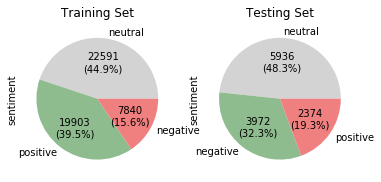

In [17]:
def show_autopct(pct, data):
  absolute = int(pct/100.*np.sum(data))
  return  "{:d}\n({:.1f}%)".format(absolute, pct)
  
plt.subplot(1, 2, 1)
task_a_train_df['sentiment'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: show_autopct(pct, task_a_train_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Training Set');


plt.subplot(1, 2, 2)
task_a_test_df['sentiment'].value_counts().plot(
    kind='pie',
    # figsize=(7,4),
    autopct=lambda pct: show_autopct(pct, task_a_test_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Testing Set');




In [18]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...
...,...,...,...,...
20474,520384978820296705,yougov,negative,"""@LouiseBaldock great work; you may or may not..."
20476,519600072971927555,yougov,neutral,"""YouGov tonight shows 2% Labour lead. So head..."
20481,519201436102848512,yougov,neutral,IF tonight's YouGov shows another Tory lead th...
20488,520337071345795073,yougov,neutral,"""Tonight's YouGov: Lab 35, Con 30, UKIP 15, Li..."


In [19]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
# negative = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'negative'].value_counts(sort=False)
# neutral = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'neutral'].value_counts(sort=False)
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

                       positive  negative  neutral
spx                           4       2.0     12.0
thor                        138      18.0      NaN
brock lesnar                108      14.0      NaN
serena                       73       1.0      NaN
digi                         72       2.0      NaN
james franklin                2      10.0      7.0
pope                         58       5.0      NaN
batman                       64       5.0      NaN
barca                        69       6.0      6.0
packers                       6       2.0     10.0
frank ocean                 110      38.0      NaN
disney                       12       1.0      7.0
ducks                         8       1.0     11.0
ihop                         81       3.0      NaN
ipad                         63       4.0      NaN
act                           1       2.0      5.0
minecraft                    82       1.0      NaN
floyd mayweather             37      27.0      NaN
sony                         49

<BarContainer object of 303 artists>

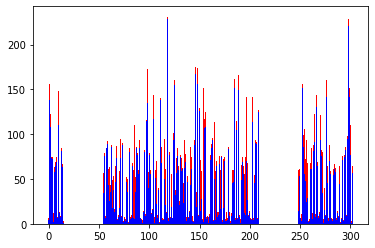

In [20]:

plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])

# Building Classifier

## Build Dataset


In [0]:
from torch.utils.data import DataLoader, Dataset
from torchtext.data import TabularDataset, Field, LabelField, BucketIterator
from sklearn.preprocessing import LabelEncoder
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.preprocessor import TextPreProcessor

In [22]:
text_processor = TextPreProcessor(
  # normalized these terms (ex: "google.com" into "<url>")
  normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
              'time', 'date', 'number'],

  # annotate these terms (ex: "#win" into ["<hashtag>", "win", "</hashtag>"])
  annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
  fix_html=True,
  segmenter = 'twitter',
  corrector='twitter',
  unpack_hashtags=True,
  unpack_contractions=True,
  spell_correct_elong=False,
  tokenizer = SocialTokenizer(lowercase=True).tokenize,
  dicts = [emoticons]
)

def custom_tokenizer(example):
  return text_processor.pre_process_doc(example)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [0]:
# read csv file as torchtext's TabularDataset
def csv_to_tabular_dataset(filepath, fields):
  tabular_daset = TabularDataset(
      path=filepath,
      fields = fields,
      format='tsv',
      skip_header=True
  )
  return tabular_daset

In [0]:
ROW_NUM = Field()

TEXT = Field(
    tokenize=custom_tokenizer,
    include_lengths=True)

SENTIMENT = LabelField(dtype = torch.int)

train_data_a = csv_to_tabular_dataset(
    cfg['paths']['cleaned_train_a'],
    fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)]
)

test_data_a = csv_to_tabular_dataset(
    cfg['paths']['cleaned_test_a'],
    fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)]
)

In [63]:
# split train data as traid:validation
train_data_a, valid_data_a = train_data_a.split(split_ratio=0.8)

print(len(train_data_a), len(train_data_a)/(len(train_data_a)+len(valid_data_a))*100)
print(len(valid_data_a), len(valid_data_a)/(len(train_data_a)+len(valid_data_a))*100)
print(len(test_data_a))


18040 80.0
4510 20.0
12284


In [26]:
vars(train_data_a.examples[0])

{'row_num': ['12547'],
 'sentiment': 'neutral',
 'text': ['oklahoma',
  "'",
  's',
  'new',
  'open',
  'carry',
  'law',
  'goes',
  'into',
  'effect',
  'today',
  '.',
  'check',
  'james',
  'keeton',
  "'",
  's',
  'article',
  'about',
  'the',
  'law',
  'in',
  'our',
  'latest',
  'issue',
  '.',
  '<url>']}

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data_a, valid_data_a, test_data_a), 
    batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

## Build Vocabulary

In [0]:
ROW_NUM.build_vocab(train_data_a)
SENTIMENT.build_vocab(train_data_a)

In [29]:
print(SENTIMENT.vocab.freqs.most_common())
for key, value in SENTIMENT.vocab.stoi.items():
  print(key, value)

[('neutral', 15820), ('positive', 13924), ('negative', 5490)]
neutral 0
positive 1
negative 2


In [0]:
import requests, zipfile, io
from pathlib import Path


vector_filepath = './crawl-300d-2M.vec'

# check if we need to download vector file
if not Path(vector_filepath).is_file():
  # download vector file (in .zip)
  r = requests.get('https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip')
  z = zipfile.ZipFile(io.BytesIO(r.content))
  # unzip the file
  z.extractall()



# link = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"

# response = requests.get(link)
# total_length = int(response.headers.get('content-length'))
# print(total_length)
# if total_length is not None: # no content length header
#     dl = 0
#     total_length = int(total_length)
#     for data in response.iter_content(chunk_size=4096):
#         dl += len(data)
#         f.write(data)
#         done = int(50 * dl / total_length)
#         sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
#         sys.stdout.flush()
# z = zipfile.ZipFile(io.BytesIO(response.content))
# z.extractall()

In [0]:
# vocab = set(train_data_a.vocab)
# type(train_data_a.vocab)
# pretrained_embedding = GloVe(name='twitter.27B', dim=200, is_include=lambda w: w in vocab)
from torchtext.vocab import Vectors


TEXT.build_vocab(train_data_a,
                 max_size = 50000,
                 vectors = Vectors(vector_filepath),
                #  vectors = 'glove.twitter.27B.200d',
                 unk_init = torch.Tensor.normal_
                 )

In [32]:

# TEXT.build_vocab(train_data_a,
#                  max_size = 50000,
#                  vectors = './crawl-300d-2M.vec',
#                 #  vectors = 'glove.twitter.27B.200d',
#                  unk_init = torch.Tensor.normal_
#                  )

# TEXT.build_vocab(train_data_a,
#                 #  max_size = 25000,
#                 #  vectors = 'glove.twitter.27B.200d',
#                 #  unk_init = torch.Tensor.normal_
#                  )


tot = 0
for batch in train_iterator:
  # print(batch.batch_size)
  tot += batch.batch_size
print(tot)

# print(len(train_data_a))

print(TEXT.vocab.freqs.most_common(100))
print(TEXT.vocab.itos[:10])

35234
[('.', 33149), ('the', 29516), ('"', 24835), ('to', 16137), (',', 13756), ('<user>', 13508), ('i', 13295), ('in', 10438), ('<url>', 10323), ('a', 10273), ('on', 10145), ('<repeated>', 10060), ('!', 9925), ('and', 9822), ('<allcaps>', 9490), ('</allcaps>', 9490), ('<number>', 9092), ('<hashtag>', 8970), ('</hashtag>', 8970), ("'", 8800), ('of', 8469), ('\\', 8184), ('is', 7757), ('for', 7671), ('it', 7145), ('you', 7004), ('s', 6780), ('-', 6138), ('with', 5852), ('tomorrow', 5730), ('be', 5611), ('at', 5490), (':', 5421), ('may', 5198), ('not', 5047), ('?', 4853), ('have', 4020), ('that', 4002), ('will', 3708), ('my', 3694), ('th', 3525), ('u002c', 3483), ('1', 3414), ('<date>', 3358), ('this', 3282), ('day', 3186), ('but', 3094), ('he', 3068), ('just', 3044), ('was', 2804), ('are', 2723), ('me', 2384), ('we', 2383), ('so', 2364), ('all', 2319), ('going', 2319), ('night', 2306), ('&', 2302), ('out', 2274), ('st', 2273), ('2', 2256), ('if', 2245), ('am', 2235), ('see', 2177), ('ca

In [33]:
 for batch in train_iterator:
  i = int(ROW_NUM.vocab.itos[int(batch.row_num[0][0])])
  print(task_a_train_df.iloc[i].text)
  for elm in torch.transpose(batch.text[0], 0, 1)[0].detach().cpu().clone().numpy().transpose():
    print(TEXT.vocab.itos[int(elm)], sep=' ', end=' ')
  # print(batch.text)
  break
  

"Gotta feel for Paul Dunne, the guy finished as the 4th amateur after having the 54-hole lead."
" gotta feel for paul dunne , the guy finished as the 4 th amateur after having the <number> - hole lead . " 

In [34]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])

[('.', 33149), ('the', 29516), ('"', 24835), ('to', 16137), (',', 13756), ('<user>', 13508), ('i', 13295), ('in', 10438), ('<url>', 10323), ('a', 10273), ('on', 10145), ('<repeated>', 10060), ('!', 9925), ('and', 9822), ('<allcaps>', 9490), ('</allcaps>', 9490), ('<number>', 9092), ('<hashtag>', 8970), ('</hashtag>', 8970), ("'", 8800)]
['<unk>', '<pad>', '.', 'the', '"', 'to', ',', '<user>', 'i', 'in']


In [35]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(SENTIMENT.vocab)}")

Unique tokens in TEXT vocabulary: 33290
Unique tokens in LABEL vocabulary: 3


## Neural Network

three layers:
1. embedding layer (transform one-hot encoding vector into a dense embedding vector)
2. RNN
3. linear layer (output)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
               bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    # self.rnn = nn.RNN(embedding_dim, hidden_dim)
    self.rnn = nn.LSTM(embedding_dim,
                       hidden_dim,
                       num_layers=n_layers,
                       bidirectional=bidirectional,
                       dropout=dropout
                       )
    self.fully_connected = nn.Linear(hidden_dim*2, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_length):
    # text dimention is [sentence len, batch size]
    
    # embedded dimention is [sentence len, batch size, embedding_dim]
    embedded = self.dropout(self.embedding(text))

    # pack the sequence
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
    # print('packed_embedded:')
    # print(packed_embedded)
    packet_output, (hidden, cell) = self.rnn(packed_embedded)

    # unpack the sequence
    output, output_length = nn.utils.rnn.pad_packed_sequence(packet_output)

    # output dimention is [sentence len, batch size, hidden dim * num directions]
    # output over padding tokens are zero tensors

    # hidden dimension is [num layers*num directions, batch size, hidden dim]
    # cell dimension is also [num layers*num directions, batch size, hidden dim]

    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
    #and apply dropout

    # hidden dimension is [batch size, hid dim*num directions]
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
    return self.fully_connected(hidden)


In [0]:
INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 200
EMBEDDING_DIM = 300
# HIDDEN_DIM = 256
HIDDEN_DIM = 512
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2
# N_LAYERS = 3

BIDIRECTIONAL = True
# DROPOUT = 0.5
DROPOUT = 0.7

N_EPOCHS = 10

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX,
            )

In [38]:
def count_model_params(model):
  # number of parameters that are trainable
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(model.parameters)
print(count_model_params(model))
print(model)


<bound method Module.parameters of RNN(
  (embedding): Embedding(33290, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.7, bidirectional=True)
  (fully_connected): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)>
19623867
RNN(
  (embedding): Embedding(33290, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.7, bidirectional=True)
  (fully_connected): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [39]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([33290, 300])


In [40]:
# replace the initial weights of the embedding layer with the pretrained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0849, -0.0582, -0.0321,  ...,  0.0032, -0.0237, -0.0366],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [41]:
# initialise UNK and PAD tokens to zeros
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0849, -0.0582, -0.0321,  ...,  0.0032, -0.0237, -0.0366],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [42]:
for p in model.parameters():
  # print(p)
  print(p.numel())

9987000
614400
1048576
2048
2048
614400
1048576
2048
2048
2097152
1048576
2048
2048
2097152
1048576
2048
2048
3072
3


## Train the Model

In [0]:
# https://github.com/drivendata/cookiecutter-data-science cookie cutter
# / boilerplate for data science/ machine learning project

In [0]:
import torch.optim as optim

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimiser = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss()

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
criterion = criterion.to(device)

cuda


In [0]:
# from torchsummary import summary

# help(summary)
# # import torchvision.models as models
# # alexnet = models.alexnet(pretrained=False)
# # alexnet.cuda()
# summary(model, [(300, 512), (300, 512)], 512, device='cuda')
# # print(alexnet)

In [0]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """

#     #round predictions to the closest integer
#     rounded_preds = torch.round(torch.sigmoid(preds))
#     rounded_preds = torch.round(preds)
#     correct = (rounded_preds == y).float() #convert into float for division
#     acc = correct.sum() / len(correct)
#     return acc

# def categorical_accuracy(preds, y):
#   """
#   Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#   """
#   max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
#   correct = max_preds.squeeze(1).eq(y)
#   return correct.sum() / torch.FloatTensor([y.shape[0]])

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
def calculate_performance(y, preds):
  # get the index of the max probability 
  max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(1)
  max_preds = max_preds.detach().cpu().clone().numpy()
  
  y = y.detach().cpu().clone().numpy()


  # max_samples = 2
  # for i in range(len(y)-1):
  #   if max_preds[i] != y[i]:
  #     print('pred=', SENTIMENT.vocab.itos[max_preds[i]], ' actual=', SENTIMENT.vocab.itos[y[i]], end=' ')
  #     for elm in torch.transpose(texts, 0, 1)[0].detach().cpu().clone().numpy().transpose():
  #       print(TEXT.vocab.itos[int(elm)], sep=' ', end=' ')
  #     print
  #     max_samples -= 1
  #   if max_samples <= 0:
  #     break

  acc = accuracy_score(y, max_preds)
  rec = recall_score(y, max_preds, average='macro')
  prec= precision_score(y, max_preds, average='macro')
  f1  = f1_score(y, max_preds, average='macro')
  return acc, rec, prec, f1



In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0

    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_length = batch.text
        # predictions = model(text).squeeze(1)
        predictions = model(text, text_length).squeeze(1)
        
        summary_writer.add_graph(model, (text, text_length))
        
        loss = criterion(predictions, batch.sentiment.long())
        
        # acc = categorical_accuracy(predictions, batch.sentiment)
        acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
        # print(acc, rec, prec, f1)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_prec += prec.item()
        epoch_f1 += f1.item()

        avg_loss = epoch_loss / len(iterator)
        avg_acc = epoch_acc / len(iterator)
        avg_rec = epoch_rec / len(iterator)
        avg_prec = epoch_prec / len(iterator)
        avg_f1 = epoch_f1 / len(iterator)

    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0
    
    model.eval()
    
    actual_file = open('actual.txt', 'w')
    pred_file = open('pred.txt', 'w')
    with torch.no_grad():
    
        for batch in iterator:
            text, text_length = batch.text
            predictions = model(text, text_length).squeeze(1)
            actuals = batch.sentiment
            for elm in actuals:
              actual_file.write(str(elm.item()) + '\n')
            
            preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
            for elm in preds:
              pred_file.write(str(elm.item()) + '\n')
 
            # loss = criterion(predictions, batch.sentiment.long())
            loss = criterion(predictions, batch.sentiment.long())
            
            # acc = categorical_accuracy(predictions, batch.sentiment)
            # acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
            acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
            # print(acc, rec, prec, f1)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_rec += rec.item()
            epoch_prec += prec.item()
            epoch_f1 += f1.item()

            avg_loss = epoch_loss / len(iterator)
            avg_acc = epoch_acc / len(iterator)
            avg_rec = epoch_rec / len(iterator)
            avg_prec = epoch_prec / len(iterator)
            avg_f1 = epoch_f1 / len(iterator)
    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
from torch.utils.tensorboard import SummaryWriter

summary_writer = SummaryWriter()

best_valid_loss = float('inf')


# --- EARLY STOPPING
use_early_stopping = True
early_stopping_patience = 0
# ------------------

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    
    train_loss, train_acc, train_rec, train_prec, train_f1 = train(model, train_iterator, optimiser, criterion)
    valid_loss, valid_acc, valid_rec, valid_prec, valid_f1 = evaluate(model, valid_iterator, criterion)

    summary_writer.add_scalar("training/loss", train_loss, epoch)
    summary_writer.add_scalar("training/accuracy", train_acc, epoch)
    summary_writer.add_scalar("training/recall", train_rec, epoch)
    summary_writer.add_scalar("training/precision", train_prec, epoch)
    summary_writer.add_scalar("training/F1", train_f1, epoch)

    summary_writer.add_scalar("validation/loss", valid_loss, epoch)
    summary_writer.add_scalar("validation/accuracy", valid_acc, epoch)
    summary_writer.add_scalar("validation/recall", valid_rec, epoch)
    summary_writer.add_scalar("validation/precision", valid_prec, epoch)
    summary_writer.add_scalar("validation/F1", valid_f1, epoch)
    
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), cfg['paths']['task_a_model'])
    else:
        early_stopping_patience -= 1   
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    print(f'\tTrain Acc : {train_acc*100:.2f}% | Val. Acc : {valid_acc*100:.2f}%')
    print(f'\tTrain Rec : {train_rec*100:.2f}% | Val. Rec : {valid_rec*100:.2f}%')
    print(f'\tTrain Prec: {train_prec*100:.2f}% | Val. Prec: {valid_prec*100:.2f}%')
    print(f'\tTrain F1  : {train_f1*100:.2f}% | Val. F1  : {valid_f1*100:.2f}%')

    # check if early stopping is needed
    if use_early_stopping:
      if early_stopping_patience < 0:
          print('Early stopping!' )
          break

# after completing all epochs, visualise the word vectors
vectors = model.embedding.weight.data
labels = [l for l in TEXT.vocab.itos]
summary_writer.add_embedding(vectors, metadata=labels)
summary_writer.close()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


do this
Epoch: 01 | Epoch Time: 1m 19s
	Train Loss: 0.663 | Val. Loss: 0.738
	Train Acc : 70.67% | Val. Acc : 68.26%
	Train Rec : 66.91% | Val. Rec : 60.12%
	Train Prec: 69.39% | Val. Prec: 68.51%
	Train F1  : 66.77% | Val. F1  : 60.82%
do this
Epoch: 02 | Epoch Time: 1m 21s
	Train Loss: 0.604 | Val. Loss: 0.704
	Train Acc : 74.03% | Val. Acc : 68.56%
	Train Rec : 71.04% | Val. Rec : 65.36%
	Train Prec: 73.15% | Val. Prec: 67.21%
	Train F1  : 70.89% | Val. F1  : 65.14%
Epoch: 03 | Epoch Time: 1m 22s
	Train Loss: 0.551 | Val. Loss: 0.704
	Train Acc : 76.79% | Val. Acc : 69.10%
	Train Rec : 74.65% | Val. Rec : 65.23%
	Train Prec: 76.16% | Val. Prec: 67.67%
	Train F1  : 74.50% | Val. F1  : 65.49%
Early stopping!


In [53]:
%tensorboard --logdir runs


Reusing TensorBoard on port 6006 (pid 1207), started 0:30:16 ago. (Use '!kill 1207' to kill it.)

<IPython.core.display.Javascript object>

In [59]:
model.load_state_dict(torch.load(cfg['paths']['task_a_model']))
test_loss, test_acc, test_rec, test_prec, test_f1 = evaluate(model, test_iterator, criterion)
#DONY
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Acc : {test_acc*100:.2f}%')
print(f'Test Rec : {test_rec*100:.2f}%')
print(f'Test Prec: {test_prec*100:.2f}%')
print(f'Test F1  : {test_f1*100:.2f}%')

Test Loss: 0.816
Test Acc : 62.68%
Test Rec : 64.75%
Test Prec: 60.76%
Test F1  : 60.52%


In [0]:
# 15 Apr
# Test Loss: 0.828
# Test Acc : 65.16%
# Test Rec : 64.89%
# Test Prec: 62.38%
# Test F1  : 62.55%

In [0]:
# summary_writer.flush()
# summary_writer.close()